In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange
from sklearn.datasets import make_moons

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
class TwoMoonsDataset(torch.utils.data.Dataset):
    """
    Dataset where targets only depend on one of the input dimensions
    We want to ensure we capture uncertainty when deviating even in the insensitive direction
    """
    def __init__(self, N=200, noise=0.2, split='train') -> None:
        super().__init__()
        if split=='train':
            random_state = 1
        elif split == 'val':
            random_state = 2
        else:
            random_state = 3
        X,y = make_moons(n_samples=N, shuffle=True, noise=noise, random_state=random_state)
        self.X = torch.from_numpy(X).float() #+ 5*torch.ones(2)
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

In [57]:
class CosineActivation(torch.nn.Module):
    def forward(self, x):
        return torch.cos(x)
    
# DNN mapping 2d input to 1d distribution parameter
small_model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 2)
)

wide_model = torch.nn.Sequential(
    torch.nn.Linear(2, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, 2)
)

dist_layer = scod.distributions.CategoricalLogitLayer()

### model training

mean_loss=0.133171: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


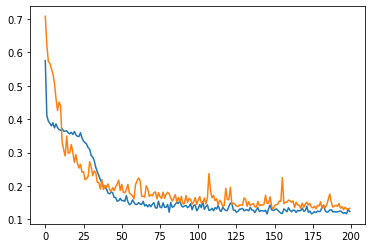

In [58]:
for model in [small_model, wide_model]:
    dataset = TwoMoonsDataset()
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses = []
    t = trange(200)

    for epoch in t:
        epoch_loss = 0.
        for (inputs, targets) in train_dataloader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            dist = dist_layer(outputs)
            loss = -dist.log_prob(targets)
            mean_loss = loss.mean()

            regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 1e3

            total_loss = mean_loss + regularization
            total_loss.backward()

            epoch_loss += total_loss
            
            optimizer.step()
            
        epoch_loss /= len(train_dataloader)
        
        t.set_description("mean_loss=%02f"%epoch_loss.item())
        losses.append(epoch_loss.item())

    plt.plot(losses)

In [60]:
small_unc_model = scod.SCOD(small_model, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

wide_unc_model = scod.SCOD(wide_model, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

Weight space dimension: 8.642e+03
Weight space dimension: 1.329e+05


### process training dataset to compute posterior uncertainty

In [61]:
small_unc_model.process_dataset(dataset, dist_layer)
wide_unc_model.process_dataset(dataset, dist_layer)

computing basis
using T = 304


  0%|          | 0/200 [00:00<?, ?it/s]

computing basis
using T = 304


  0%|          | 0/200 [00:00<?, ?it/s]

### compare SCOD's predictions to the original trained model

In [62]:
settings = [
    {   
        'name': 'Hidden Size = 64',
        'model': small_unc_model,
    },
    {   
        'name': 'Hidden Size = 256',
        'model': wide_unc_model,
    },
]

In [63]:
X1,X2 = np.meshgrid( np.linspace(-5.,5.,50), np.linspace(-5.,5.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()

In [64]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    _, prior_z_var = scod_model(xx_tensor, use_prior=True)

    raw_dist = dist_layer(z_mean)
    raw_uncs = raw_dist.entropy().detach().cpu().numpy()

    prior_dist = dist_layer.marginalize_gaussian(z_mean, prior_z_var)
    dist = dist_layer.marginalize_gaussian(z_mean, z_var)

    prior_probs = prior_dist.probs[:,1].detach().cpu().numpy()
    prior_zvars = prior_z_var.sum(-1).detach().cpu().numpy()
    prior_uncs = prior_dist.entropy().detach().cpu().numpy()
    
    probs = dist.probs[:,1].detach().cpu().numpy()
    zvars = z_var.sum(-1).detach().cpu().numpy()
    uncs = dist.entropy().detach().cpu().numpy()

    result = {
        'name': setting['name'],
        'raw_uncs': raw_uncs.reshape(X1.shape),
        'probs': probs.reshape(X1.shape),
        'zvars': zvars.reshape(X1.shape),
        'uncs': uncs.reshape(X1.shape),
        'prior_probs': prior_probs.reshape(X1.shape),
        'prior_zvars': prior_zvars.reshape(X1.shape),
        'prior_uncs': prior_uncs.reshape(X1.shape)
    }
    results.append(result)

Text(0.5, 1.0, 'Raw Entropy')

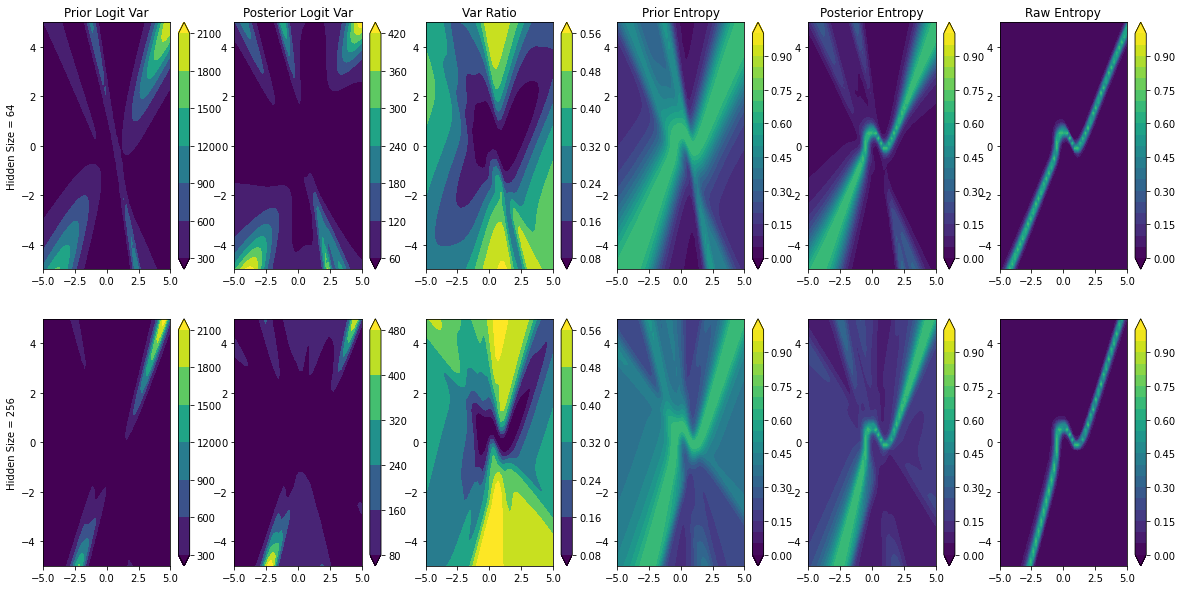

In [66]:
fig, axes = plt.subplots(len(results), 6, figsize=[20,10])
for i, result in enumerate(results):
    m = axes[i,0].contourf(X1,X2,result['prior_zvars'], extend='both')
    plt.colorbar(m, ax=axes[i,0])

    m = axes[i,1].contourf(X1,X2,result['zvars'], extend='both')
    plt.colorbar(m, ax=axes[i,1])

    m = axes[i,2].contourf(X1,X2,result['zvars'] / result['prior_zvars'], extend='both')
    plt.colorbar(m, ax=axes[i,2])

    m = axes[i,3].contourf(X1,X2,result['prior_uncs'], vmin=0., vmax=1., extend='both', levels=np.linspace(0,1,21))
    plt.colorbar(m, ax=axes[i,3])

    m = axes[i,4].contourf(X1,X2,result['uncs'], vmin=0., vmax=1., extend='both', levels=np.linspace(0,1,21))
    plt.colorbar(m, ax=axes[i,4])

    m = axes[i,5].contourf(X1,X2,result['raw_uncs'], vmin=0., vmax=1., extend='both', levels=np.linspace(0,1,21))
    plt.colorbar(m, ax=axes[i,5])

    # axes[i,2].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0, vmax=1, edgecolors='k')


    # axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='white', alpha=0.1)
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Logit Var')
axes[0,1].set_title('Posterior Logit Var')
axes[0,2].set_title('Var Ratio')
axes[0,3].set_title('Prior Entropy')
axes[0,4].set_title('Posterior Entropy')
axes[0,5].set_title('Raw Entropy')